<a href="https://colab.research.google.com/github/aparnasree2020/CAS_RPM_2023_GBM/blob/main/RPM_XGBoost_Models_AXS_1M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to CAS RPM - XGboost

In [ ]:
print("Welcome to CAS RPM 2023 - XGboost")

[1] "Welcome to CAS RPM 2023 - XGboost"


# Install packages

* Here we will install the packages necessary to run the XGBoost part of the workshop.

* The installation will take about 10 minutes

* We check if the libraries are installed, if they are already installed, then we do not reinstall them.

In [1]:
start_time <- Sys.time()

if (!require(xgboost)) {
  install.packages("xgboost")
  library(xgboost)
}
if (!require(pROC)) {
  install.packages("pROC")
  library(pROC)
}
if (!require(reshape2)) {
  install.packages("reshape2")
  library(reshape2)
}

end_time <- Sys.time()
elapsed_time <- difftime(end_time, start_time, units = "secs")
print(paste("Installation of libraries took: ", round(elapsed_time/60, 2), " minutes"))

Loading required package: xgboost

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘xgboost’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: pROC

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pROC’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: reshape2

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘reshape2’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "Installation of libraries took:  11.82  minutes"


# Load Libraries

In [2]:
library(dplyr)
library(tidyverse)
library(xgboost)
library(pROC)
library(reshape2)


Attaching package: ‘dplyr’


The following object is masked from ‘package:xgboost’:

    slice


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.3.0     ✔ forcats 1.0.0
✔ readr   2.1.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::slice()  masks xgboost::slice()



# Create Plotting functions

In [3]:
avse.plot.classification <- function(data,var,actual,pred,weight,rt_text,lt_text) {
  header = "Actual vs Predicted"

  home_plot <- data %>%
    mutate(nt = eval(parse(text = var))) %>%
    group_by(nt) %>%
    summarize(  act = sum(eval(parse(text = actual)))
                , pred = sum(eval(parse(text = pred)))
                , exposures = sum(eval(parse(text = weight)))
    ) %>%
    mutate(   actual = act/exposures
              , predicted = pred/exposures)
  
  home_plot <- home_plot[complete.cases(home_plot),]
  
  # off balance for model total prediction
  a1 = paste0("data$",actual)
  a2 = paste0("data$",pred)
  off_balance = sum(eval(parse(text = a1)))/sum(eval(parse(text = a2)))
  home_plot$predicted <- home_plot$predicted*off_balance
  
  par(mar=c(5, 4, 2, 5) + 0.1)
  
  barplot(home_plot$exposures,las=2,col="lightblue",ylim = c(0,max(home_plot$exposures)*1.1))
  par(new=TRUE)
  plot(home_plot$nt, home_plot$actual, col='darkblue',lwd= 4, axes=FALSE, ylim=c(ifelse(min(home_plot$actual)<min(home_plot$predicted),min(home_plot$actual)*0.98,min(home_plot$predicted)*0.98),ifelse(max(home_plot$actual)>max(home_plot$predicted),max(home_plot$actual)*1.02,max(home_plot$predicted)*1.02)), xlab="", ylab="",main=header)
  axis(4, ylim=c(0,1),col="black",las=1)
  axis(1, xlim=c(0,1),col="black",las=1)
  mtext(rt_text,side=4,line=3.0,col="black",font=7)
  mtext(lt_text, side = 2, line=3.0,col="black",font=7)
  box()
  mtext(var,side=1,col="black",line=2.5,font=7) 
  lines(home_plot$nt,home_plot$predicted, col="green",lwd=3)  
}

# Load CSV datafile 
## *  Data split as train and test (80/20 split) 

*   Train data - Used for model training
*   Test data - Hold out data used for evaluating model performance

In [60]:
path <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/gbm_data_rpm_2023_1M_v3.zip"
temp <- tempfile()
download.file(path, temp)
unzip(temp, "gbm_data_rpm_2023_1M_v3.csv")
gbm_data <- read.csv("gbm_data_rpm_2023_1M_v3.csv")
unlink(temp)
full_data = gbm_data


In [62]:
set.seed(031311)
trim <- sample(c(TRUE, FALSE), nrow(full_data), replace=TRUE, prob=c(0.4, 0.6))
trim_data <- full_data[trim, ]
holdout_data <- full_data[!trim, ]

sample <- sample(c(TRUE, FALSE), nrow(trim_data), replace=TRUE, prob=c(0.8,0.2))
train_data  <- trim_data[sample, ]
test_data   <- trim_data[!sample, ]

x_train <- train_data[,!names(train_data) %in% "claim_count_pd"]
y_train <- train_data[,names(train_data) %in% "claim_count_pd"]

x_test <- test_data[,!names(test_data) %in% "claim_count_pd"]
y_test <- test_data[,names(test_data) %in% "claim_count_pd"]

In [63]:
nrow(x_train)
ncol(x_train)
nrow(x_test)
ncol(x_test)


[1] 320179

[1] 35

[1] 80074

[1] 35

In case you want to look at the data a bit before we get into the modeling.

In [64]:
colnames(train_data)

[1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "claim_count_pd"              "geo_pop_density_ntile"      
[19] "geo_median_home_value_ntile" "geo_unemployment_pct_ntile" 
[21] "geo_vacant_pct_ntile"        "geo_crime_index_ntile"      
[23] "geo_bach_pct_ntile"          "prior_claim_freq_bi"        
[25] "prior_claim_freq_pd"         "prior_claim_freq_med"       
[27] "prior_claim_freq_pip"        "prior_claim_freq_um"        
[29] "prior_claim_freq_uim"        "prior_claim_freq_coll"      
[31] "prior_claim_freq_comp"       "prior_claim_freq_tot"       
[33] "AAM"                         "NOO"                        
[35] "LOO"                         "est_current_odo"

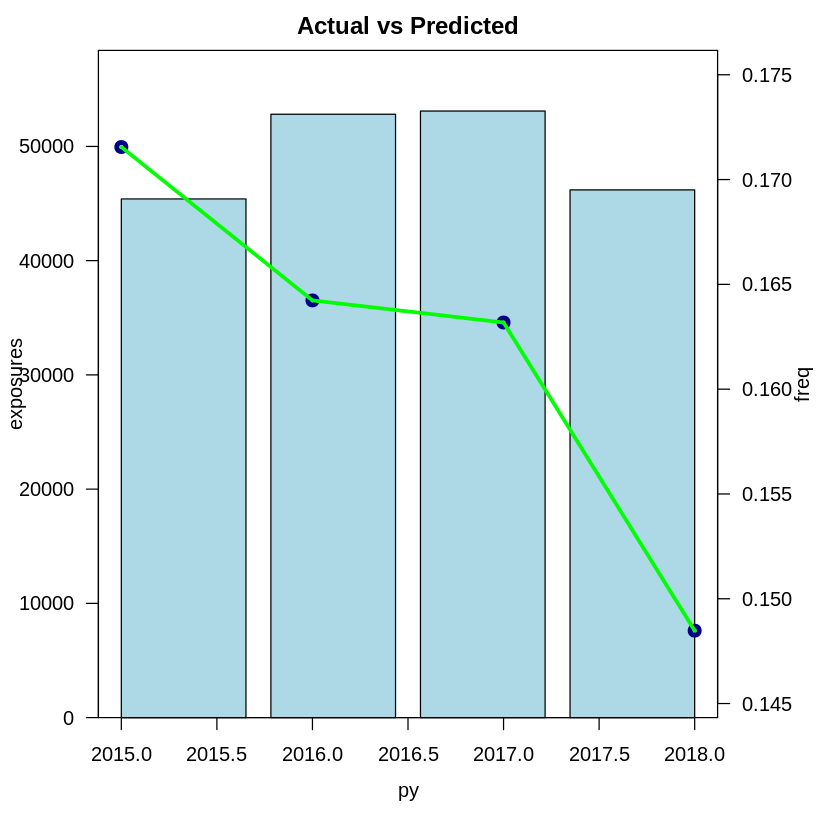

In [69]:
# train_data$nt <- ntile(train_data$LOO, 10)
avse.plot.classification(var="py",data=train_data,actual="claim_count_pd",pred="claim_count_pd",weight="ee_pd",lt_text="exposures",rt_text="freq")

# Fit a standard GLM 

In [70]:
# Set up a place to collect predictions (and a classification from each model)
df_train_pred <- data.frame(y_train)
df_test_pred <- data.frame(y_test)
df_train_pred_bin <- data.frame(y_train)
df_test_pred_bin <- data.frame(y_test)

In [71]:
# Fit a GLM
fit <- step(glm(y_train ~ ., data = x_train, family = "binomial"), direction = "both", trace = FALSE)
df_train_pred$pred_y_GLM_init <- predict(fit, newdata = x_train, type = "response")
df_test_pred$pred_y_GLM_init <- predict(fit, newdata = x_test, type = "response")
df_train_pred_bin$pred_y_GLM_init <- ifelse(df_train_pred$pred_y_GLM_init > 0.1, 1, 0)
df_test_pred_bin$pred_y_GLM_init <- ifelse(df_test_pred$pred_y_GLM_init > 0.1, 1, 0)

In [72]:
df.tmp.train <- data.frame(x_train, df_train_pred)
df.tmp.test <- data.frame(x_test, df_test_pred)

In [74]:
nrow(df.tmp.test)

[1] 80074

In [75]:
# Let's build prediction bands for lift table review
df.tmp.train <- df.tmp.train %>%
  mutate(freq_nt = ntile(pred_y_GLM_init/ee_pd,10))
df.tmp.test <- df.tmp.test %>%
  mutate(freq_nt = ntile(pred_y_GLM_init/ee_pd,10))

In [76]:
# Get list of variables to make the function call below easier
colnames(df.tmp.train)

[1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "geo_pop_density_ntile"       "geo_median_home_value_ntile"
[19] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
[21] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[23] "prior_claim_freq_bi"         "prior_claim_freq_pd"        
[25] "prior_claim_freq_med"        "prior_claim_freq_pip"       
[27] "prior_claim_freq_um"         "prior_claim_freq_uim"       
[29] "prior_claim_freq_coll"       "prior_claim_freq_comp"      
[31] "prior_claim_freq_tot"        "AAM"                        
[33] "NOO"                         "LOO"                        
[35] "est_current_odo"             "y_train"                    
[37] "pred_y_GLM_init"             "freq_nt"

In [85]:
# in case you need to bin for viewing - we'll use a single column repeatedly for this purpose rather than bloating the file
var.group = "est_current_odo"
df.tmp.train <- df.tmp.train %>%
  mutate(nt = ntile(eval(parse(text = var.group)), 10))
df.tmp.test <- df.tmp.test %>%
  mutate(nt = ntile(eval(parse(text = var.group)), 10))

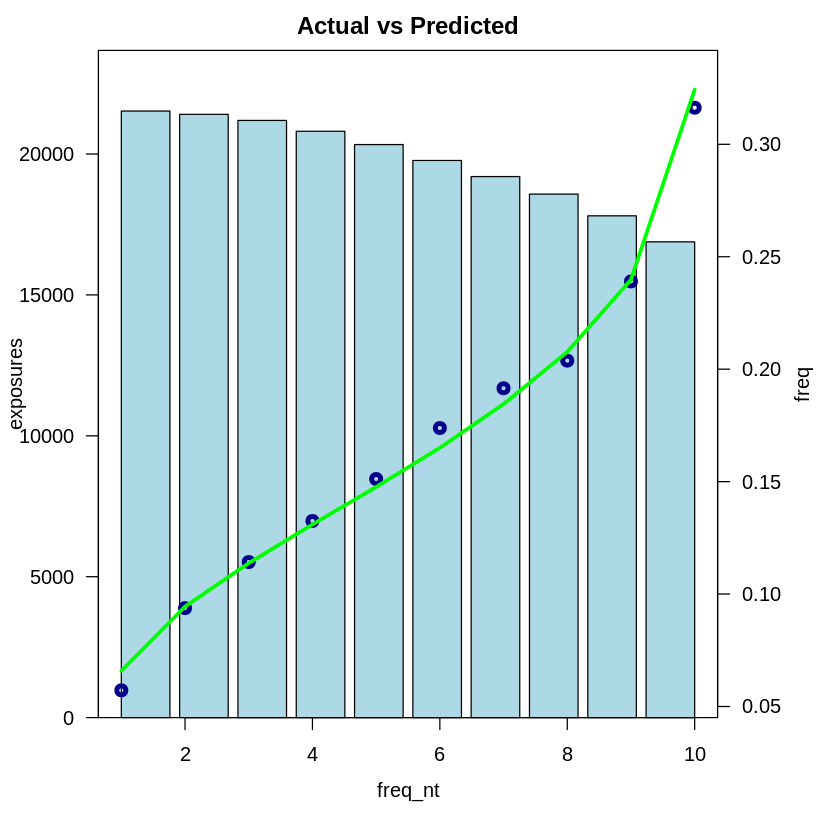

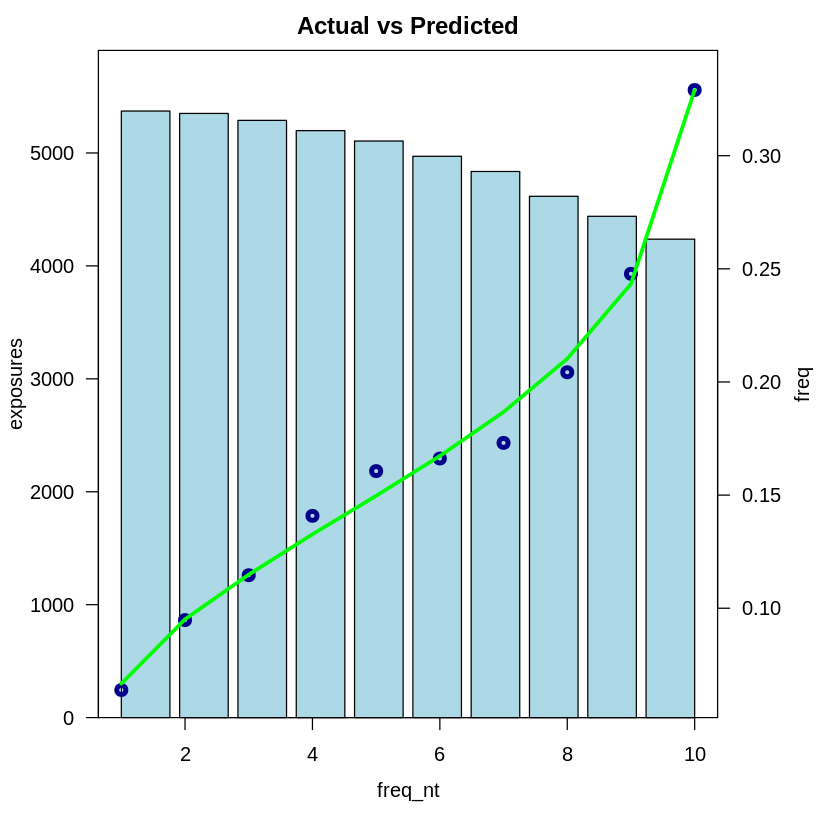

In [88]:
var.curr = "freq_nt"
avse.plot.classification(var=var.curr,data=df.tmp.train,actual="y_train",pred="pred_y_GLM_init",weight="ee_pd",lt_text="exposures",rt_text="freq")
avse.plot.classification(var=var.curr,data=df.tmp.test,actual="y_test",pred="pred_y_GLM_init",weight="ee_pd",lt_text="exposures",rt_text="freq")



#XGboost with essential hyperparameters 

All features are used for this fit

In [89]:
print(colnames(x_train))

 [1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "geo_pop_density_ntile"       "geo_median_home_value_ntile"
[19] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
[21] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[23] "prior_claim_freq_bi"         "prior_claim_freq_pd"        
[25] "prior_claim_freq_med"        "prior_claim_freq_pip"       
[27] "prior_claim_freq_um"         "prior_claim_freq_uim"       
[29] "prior_claim_freq_coll"       "prior_claim_freq_comp"      
[31] "prior_claim_freq_to

Convert data to XGB format

In [90]:
dtrain <- xgb.DMatrix(data = as.matrix(x_train)
                        , label = y_train
  )
dtest <- xgb.DMatrix(data = as.matrix(x_test)
                       , label = y_test
  )


## Explanation of Weights

*   The XGboost has a feature "scale_pos_weight" which is a hyperparameter in XGBoost that adjusts the weight of positive samples relative to negative samples in imbalanced datasets. It is defined as the ratio of the number of negative samples to the number of positive samples and is used to help the model learn more from the minority class.

*    This is an important hyper parameter, especially for classification task with unbalanced dataset. 
---

## Explanation of AUC 
* XGboost has another feature "eval_metric = "auc", AUC stands for Area Under the Curve and is a measure of the performance of a binary classifier. It represents the degree or measure of separability between the true positive rate (TPR) and the false positive rate (FPR). AUC ranges from 0 to 1, where an AUC of 1 indicates perfect classification performance, and an AUC of 0.5 indicates a random classification. AUC is commonly used to compare the performance of different models, and it is considered a more reliable measure than accuracy in imbalanced datasets.

---
## Explanation of eta ( also known as learning rate)  
The learning rate controls the magnitude of the updates to the model weights during training. A smaller learning rate means that the model makes smaller updates to the weights at each iteration, which can result in slower convergence but can also help prevent overfitting. On the other hand, a larger learning rate can lead to faster convergence but may also result in overfitting or instability.
* The learning rate is also multiplied by a shrinkage factor (denoted by the parameter lambda or alpha) to further control the magnitude of the updates. The idea is to have a larger learning rate in the beginning of the optimization. As you get closer to the global minima, the idea is to reduce the learning rate. 

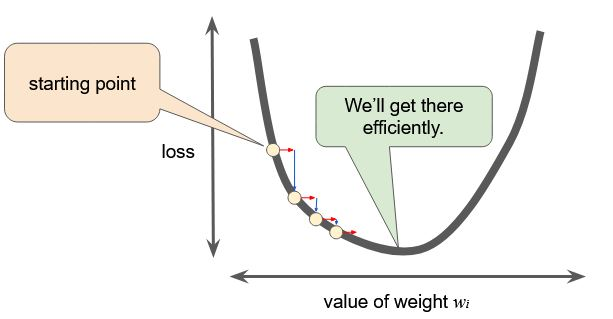

Reference 
https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate 

In [91]:
# First, a simple XGB
fit <- xgboost(data = dtrain,
               nrounds = 100,
               objective = "binary:logistic",
               eta = 0.5,
               max_depth = 9,
               eval_metric = "auc",
               verbose = 0)

df_train_pred$pred_y_XGB_init <- predict(fit, dtrain)
df_test_pred$pred_y_XGB_init <- predict(fit, dtest)
df_train_pred_bin$pred_y_XGB_init <- ifelse(df_train_pred$pred_y_XGB_init > 0.1, 1, 0)
df_test_pred_bin$pred_y_XGB_init <- ifelse(df_test_pred$pred_y_XGB_init > 0.1, 1, 0)

In [92]:
head(df_test_pred)

,y_test,pred_y_GLM_init,pred_y_XGB_init
,<int>,<dbl>,<dbl>
1,0,0.05891462,0.02037030
2,0,0.12665252,0.04926784
3,0,0.07843447,0.04857564
4,0,0.08786813,0.06329337
5,0,0.09749226,0.13261124
6,0,0.13019028,0.09929678


In [93]:
# Calculate weights based on ratio of classes
pos_weight <- sum(y_train == 0) / sum(y_train == 1)
print(pos_weight)
fit <- xgboost(data = dtrain,
               nrounds = 100,
               objective = "binary:logistic",
               eta = 0.5,
               max_depth = 9,
               eval_metric = "auc",
               scale_pos_weight = pos_weight,
               verbose = 0)

df_train_pred$pred_y_XGB_balanced <- predict(fit, dtrain)
df_test_pred$pred_y_XGB_balanced <- predict(fit, dtest)
df_train_pred_bin$pred_y_XGB_balanced <- ifelse(df_train_pred$pred_y_XGB_balanced > 0.5, 1, 0)
df_test_pred_bin$pred_y_XGB_balanced <- ifelse(df_test_pred$pred_y_XGB_balanced > 0.5, 1, 0)

[1] 9.009973


In [94]:
quiet.setting = TRUE
roc_train <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB_balanced, quiet=quiet.setting)
roc_test <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB_balanced, quiet=quiet.setting)
roc_train
roc_test


Call:
roc.default(response = df_train_pred$y_train, predictor = df_train_pred$pred_y_XGB_balanced,     quiet = quiet.setting)

Data: df_train_pred$pred_y_XGB_balanced in 288193 controls (df_train_pred$y_train 0) < 31986 cases (df_train_pred$y_train 1).
Area under the curve: 0.9462


Call:
roc.default(response = df_test_pred$y_test, predictor = df_test_pred$pred_y_XGB_balanced,     quiet = quiet.setting)

Data: df_test_pred$pred_y_XGB_balanced in 71966 controls (df_test_pred$y_test 0) < 8108 cases (df_test_pred$y_test 1).
Area under the curve: 0.5983

### Insights 
Since the AUC here is near 1.0, (we wish) we can consider this to be a good model. But, clearly we're overfitting, per the test data AUC of 0.60. In the interest of time, let's fast forward to choosing a different hyperparameters to improve on the gap.

In [95]:
# First, let's go with some pet hyperparameters
fit <- xgboost(data = dtrain,
               nrounds = 100,
               objective = "binary:logistic",
               eta = 0.1,
               max_depth = 6,
               subsample = 0.6,
               colsample_bytree = 0.6,
               verbose = 0)

df_train_pred$pred_y_XGB2 <- predict(fit, dtrain)
df_test_pred$pred_y_XGB2 <- predict(fit, dtest)
df_train_pred_bin$pred_y_XGB2 <- ifelse(df_train_pred$pred_y_XGB2 > 0.5, 1, 0)
df_test_pred_bin$pred_y_XGB2 <- ifelse(df_test_pred$pred_y_XGB2 > 0.5, 1, 0)

In [96]:
quiet.setting = TRUE
roc_train <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB2, quiet=quiet.setting)
roc_test <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB2, quiet=quiet.setting)
roc_train
roc_test


Call:
roc.default(response = df_train_pred$y_train, predictor = df_train_pred$pred_y_XGB2,     quiet = quiet.setting)

Data: df_train_pred$pred_y_XGB2 in 288193 controls (df_train_pred$y_train 0) < 31986 cases (df_train_pred$y_train 1).
Area under the curve: 0.6984


Call:
roc.default(response = df_test_pred$y_test, predictor = df_test_pred$pred_y_XGB2,     quiet = quiet.setting)

Data: df_test_pred$pred_y_XGB2 in 71966 controls (df_test_pred$y_test 0) < 8108 cases (df_test_pred$y_test 1).
Area under the curve: 0.6632

## Importance matrix

The importance matrix in XGBoost is a tool that helps to measure the relative importance of each feature in the model. It is calculated based on the contribution of each feature to the reduction of the loss function during training. There are two types of importance matrices in XGBoost: weight-based and gain-based. The importance matrix can be used for feature selection or dimensionality reduction, and it can be visualized using a bar chart or heatmap to make it easier to interpret the results.

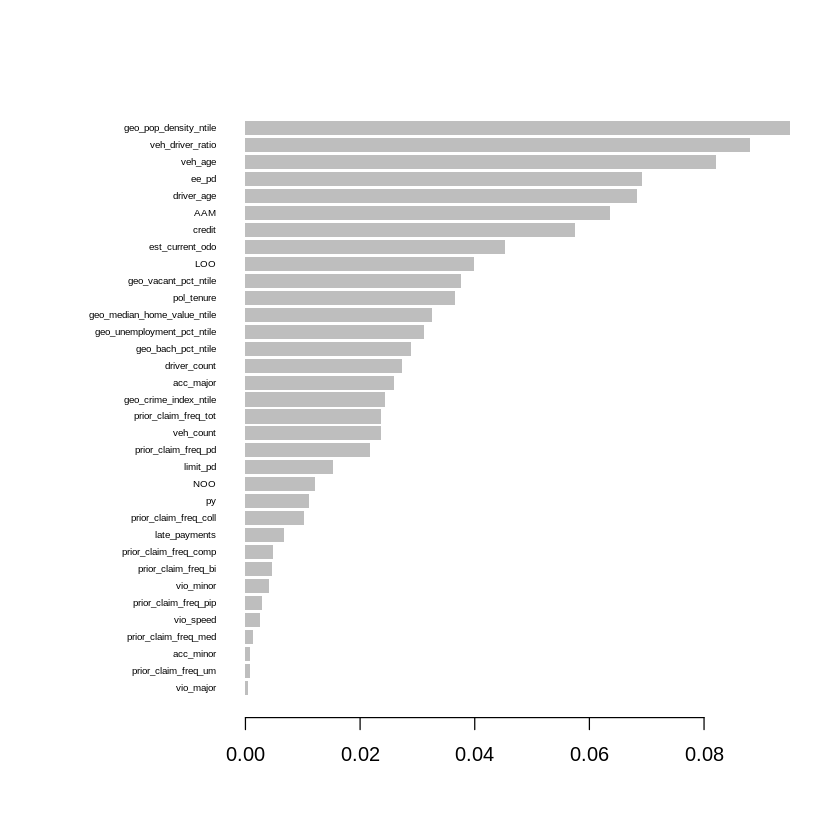

In [97]:
importance_matrix <- xgb.importance(colnames(dtrain), model = fit)
importance_matrix <- subset(importance_matrix, select = c(Feature,Gain))
  
xgb.plot.importance(importance_matrix) 
top_15_features <- head(importance_matrix$Feature, 15)

In [98]:
print(top_15_features)

 [1] "geo_pop_density_ntile"       "veh_driver_ratio"           
 [3] "veh_age"                     "ee_pd"                      
 [5] "driver_age"                  "AAM"                        
 [7] "credit"                      "est_current_odo"            
 [9] "LOO"                         "geo_vacant_pct_ntile"       
[11] "pol_tenure"                  "geo_median_home_value_ntile"
[13] "geo_unemployment_pct_ntile"  "geo_bach_pct_ntile"         
[15] "driver_count"               


In [99]:
df.tmp.train <- data.frame(x_train, df_train_pred)
df.tmp.test <- data.frame(x_test, df_test_pred)
colnames(df.tmp.train)

[1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "geo_pop_density_ntile"       "geo_median_home_value_ntile"
[19] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
[21] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[23] "prior_claim_freq_bi"         "prior_claim_freq_pd"        
[25] "prior_claim_freq_med"        "prior_claim_freq_pip"       
[27] "prior_claim_freq_um"         "prior_claim_freq_uim"       
[29] "prior_claim_freq_coll"       "prior_claim_freq_comp"      
[31] "prior_claim_freq_tot"        "AAM"                        
[33] "NOO"                         "LOO"                        
[35] "est_current_odo"             "y_train"                    
[37] "pred_y_GLM_init"             "pred_y_XGB_init"            
[39] "pred_y_XGB_balanced"         "pred_y_XGB2"

In [107]:
# Let's build prediction bands for lift table review
df.tmp.train <- df.tmp.train %>%
  mutate(freq_nt = ntile(pred_y_XGB2/ee_pd,10))
df.tmp.test <- df.tmp.test %>%
  mutate(freq_nt = ntile(pred_y_XGB2/ee_pd,10))

In [101]:
# Again, in case we need variable binning
var.group = "freq_nt"
df.tmp.train <- df.tmp.train %>%
  mutate(nt = ntile(eval(parse(text = var.group)), 10))
df.tmp.test <- df.tmp.test %>%
  mutate(nt = ntile(eval(parse(text = var.group)), 10))

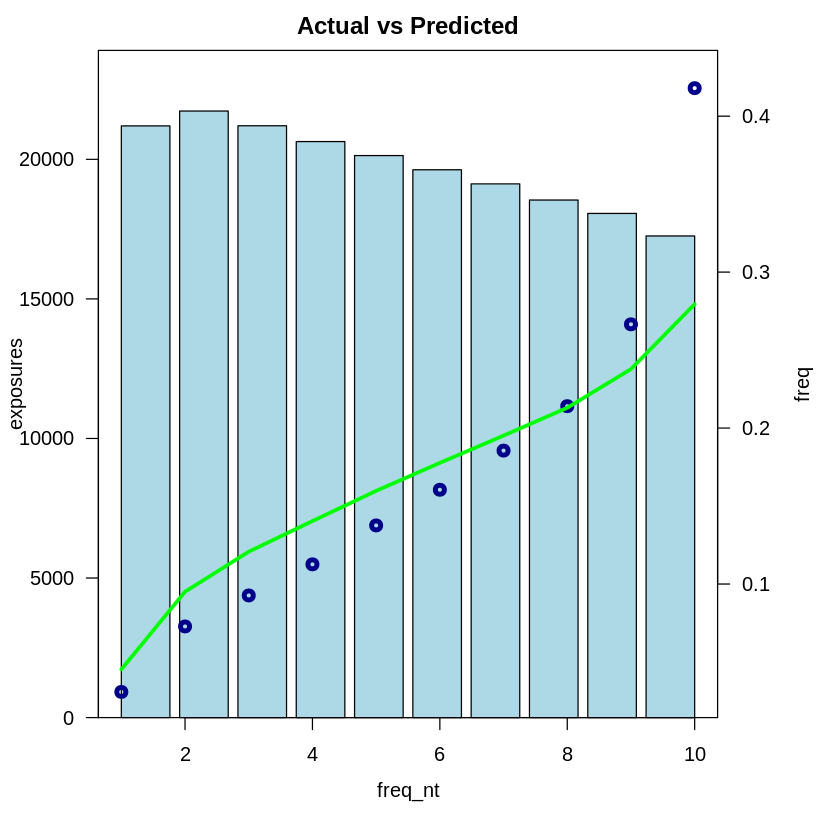

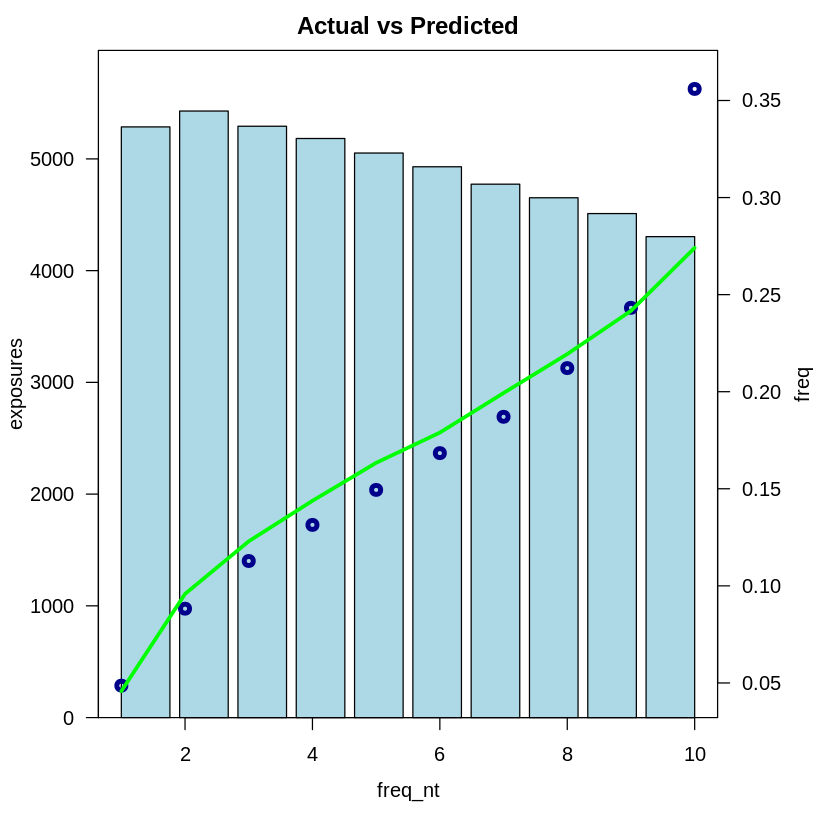

In [108]:
var.curr = "freq_nt"
avse.plot.classification(var=var.curr,data=df.tmp.train,actual="y_train",pred="pred_y_XGB_balanced",weight="ee_pd",lt_text="exposures",rt_text="freq")
avse.plot.classification(var=var.curr,data=df.tmp.test,actual="y_test",pred="pred_y_XGB_balanced",weight="ee_pd",lt_text="exposures",rt_text="freq")

### Improving GLM using XGboost insights 

In this secion, we will try to improve the GLM output based on results from Xgboost. 


1. Reduce number of features based on XGboost ( feature selection) 
2. Use appropriate weight function and evaluation metric ( AUC) 




In [109]:
x_train_top15 <- x_train[, c(top_15_features)]
x_test_top15 <- x_test[, c(top_15_features)]
#print(x_train)



In [110]:
head(x_test_top15)

,geo_pop_density_ntile,veh_driver_ratio,veh_age,ee_pd,driver_age,AAM,credit,est_current_odo,LOO,geo_vacant_pct_ntile,pol_tenure,geo_median_home_value_ntile,geo_unemployment_pct_ntile,geo_bach_pct_ntile,driver_count
,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
3,23,2.0000000,12,0.5,49,7000,5,200000,9,58,0,14,52,9,1
6,44,1.5000000,10,1.0,34,13000,5,115000,7,66,2,60,36,86,2
15,56,1.0000000,5,0.5,59,4000,6,55000,6,59,10,15,92,33,2
20,48,1.0000000,8,0.5,61,4500,7,50000,6,35,2,20,58,40,2
47,37,1.5000000,2,0.5,22,23000,6,50000,2,57,2,24,29,27,2
60,63,0.6665039,19,0.5,52,13500,7,200000,4,13,1,38,53,66,3


In [111]:
# Fit a GLM
fit <- glm(y_train ~ ., data = x_train_top15, family = "binomial")
df_train_pred$pred_y_GLM2 <- predict(fit, newdata = x_train_top15, type = "response")
df_test_pred$pred_y_GLM2 <- predict(fit, newdata = x_test_top15, type = "response")
df_train_pred_bin$pred_y_GLM2 <- ifelse(df_train_pred$pred_y_GLM2 > 0.1, 1, 0)
df_test_pred_bin$pred_y_GLM2 <- ifelse(df_test_pred$pred_y_GLM2 > 0.1, 1, 0)

## Introduce Exposure as a "base_margin"


* Introducing exposure as a "base_margin" in XGBoost provides the model with prior knowledge about the expected value of the target variable for each training instance.
* Exposure is the amount of risk that an insurance policy or portfolio of policies is exposed to over time, measured in units like person-years or vehicle-years.
* Setting the "base_margin" parameter to the logarithm of the exposure can help the model learn faster and converge to a better solution, but can also introduce bias if the exposure is not a good proxy for the target variable.



In [112]:
x_train2 <- x_train[, -which(names(x_train) == "ee_pd")]
x_test2 <- x_test[, -which(names(x_test) == "ee_pd")]

dtrain_exp <- xgb.DMatrix(data = as.matrix(x_train2)
                        , label = y_train
  )
setinfo(dtrain_exp, "base_margin", log(x_train$ee_pd))

dtest_exp <- xgb.DMatrix(data = as.matrix(x_test2)
                       , label = y_test
  )
setinfo(dtest_exp, "base_margin", log(x_test$ee_pd))

# create a dataset with no exposure adjustment, since test data may not have exposure as input
# Note that we are not using the Setinfo parameter
dtest_noexp <- xgb.DMatrix(data = as.matrix(x_test2)
                       , label = y_test
  )
watchlist <- list(train = dtrain_exp, test = dtest_noexp)


[1] TRUE

[1] TRUE

In [124]:
quiet.setting = TRUE
# Define hyperparameters
set.seed(123)
params <- list(
  objective = "binary:logistic",
  eval_metric = "auc",
  eta = 0.05,
  max_depth = 6,
  subsample = 0.6,
  colsample_bytree = 0.6
)

num_round <- 1000

# Train the model with early stopping; so giving a large num_round is fine. 
# Early stopping is a mechanism by which xgboost detects if the test/validation data is getting more error.
# early_stopping_rounds = 20, is the number of iterations for which the algorithm will wait before calling it.
model_xgbexp <- xgb.train(
  params = params,
  data = dtrain_exp,
  nrounds = num_round,
  watchlist = watchlist,
  early_stopping_rounds = 10,
  verbose = 0
)

df_train_pred$pred_y_XGB3_exp <- predict(model_xgbexp, dtrain_exp)
df_test_pred$pred_y_XGB3_exp <- predict(model_xgbexp, dtest_exp)
df_test_pred$pred_y_XGB3_noexp <- predict(model_xgbexp, dtest_noexp)

df_train_pred_bin$pred_y_XGB3_exp <- ifelse(df_train_pred$pred_y_XGB3_exp > 0.1, 1, 0)
df_test_pred_bin$pred_y_XGB3_exp <- ifelse(df_test_pred$pred_y_XGB3_exp > 0.1, 1, 0)
df_test_pred_bin$pred_y_XGB3_noexp <- ifelse(df_test_pred$pred_y_XGB3_noexp > 0.1, 1, 0)

In [125]:
quiet.setting = TRUE
roc_train <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB3_exp, quiet=quiet.setting)
roc_test <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB3_exp, quiet=quiet.setting)
roc_train
roc_test


Call:
roc.default(response = df_train_pred$y_train, predictor = df_train_pred$pred_y_XGB3_exp,     quiet = quiet.setting)

Data: df_train_pred$pred_y_XGB3_exp in 288193 controls (df_train_pred$y_train 0) < 31986 cases (df_train_pred$y_train 1).
Area under the curve: 0.6925


Call:
roc.default(response = df_test_pred$y_test, predictor = df_test_pred$pred_y_XGB3_exp,     quiet = quiet.setting)

Data: df_test_pred$pred_y_XGB3_exp in 71966 controls (df_test_pred$y_test 0) < 8108 cases (df_test_pred$y_test 1).
Area under the curve: 0.6642

# Results and summary

Model Name  | Variable Name | Description | Color
-------------------|----------| --------|------------------
GLM1      | pred_y_GLM_init | Initial GLM  | blue 
XGB1       |pred_y_XGB_init |Initial XGboost | purple 
XGB2       | pred_y_XGB2| XGBoost with pet parameters | green 
GLM2       |pred_y_GLM2 | GLM optimized with XGboost insights | red 
XGB3_exp   |pred_y_XGB3_exp | XGBoost with advanced hyper parameter | black
XGB3_noexp |pred_y_XGB3_noexp | XGBoost with exposure as basemargin | cyan 

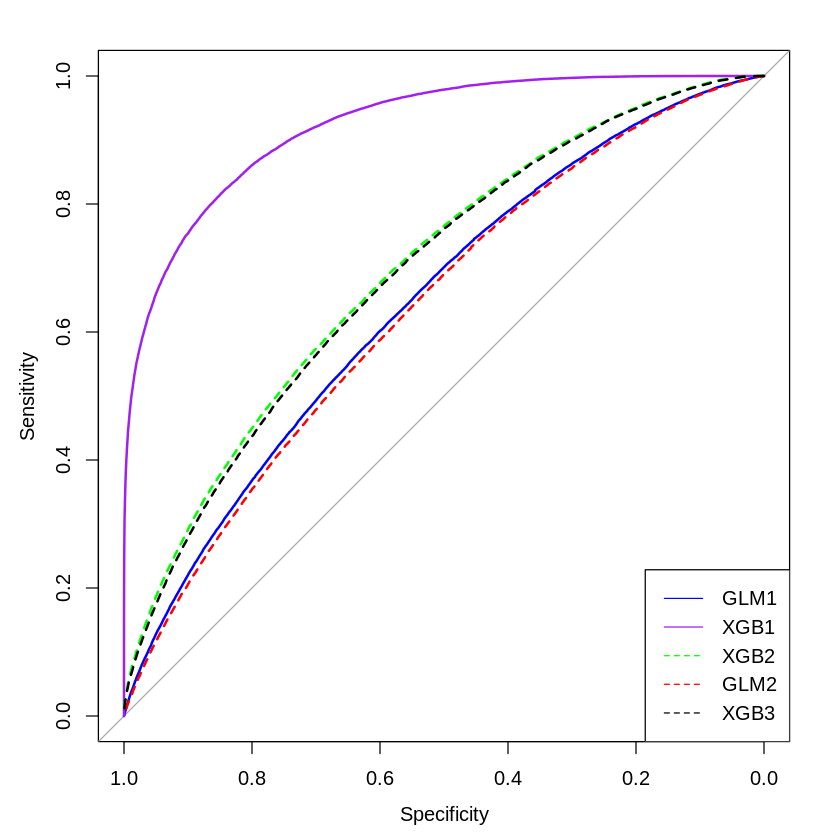

In [126]:
# Create a ROC curve for training data
quiet.setting = TRUE
roc_curve1 <- roc(df_train_pred$y_train, df_train_pred$pred_y_GLM_init, quiet=quiet.setting)
roc_curve2 <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB_init, quiet=quiet.setting)
roc_curve3 <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB2, quiet=quiet.setting)
roc_curve4 <- roc(df_train_pred$y_train, df_train_pred$pred_y_GLM2, quiet=quiet.setting)
roc_curve5 <- roc(df_train_pred$y_train, df_train_pred$pred_y_XGB3_exp, quiet=quiet.setting)

plot(roc_curve1, col = "blue", type="l", lty=1)
lines(roc_curve2, col = "purple", lty=1)
lines(roc_curve3, col = "green", lty=2)
lines(roc_curve4, col = "red", lty=2)
lines(roc_curve5, col = "black", lty=2)

# Add a legend
legend("bottomright", legend = c("GLM1", "XGB1", "XGB2", "GLM2", "XGB3"),
       col = c("blue", "purple","green", "red","black"), lty = c(1, 1, 2, 2, 2))

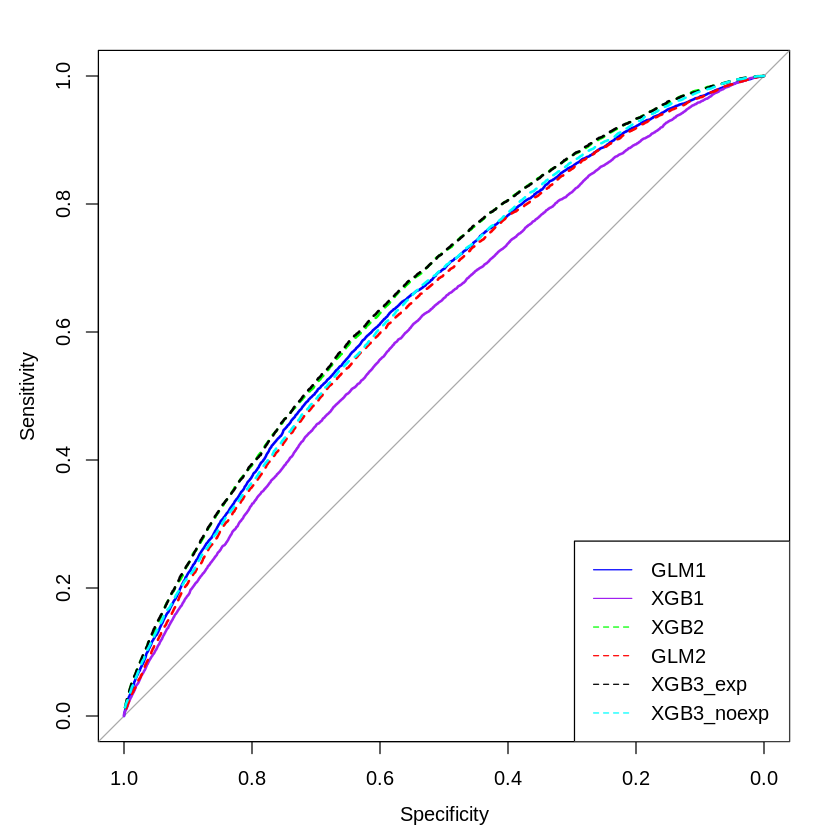

In [127]:
# Create a ROC curve
quiet.setting = TRUE
roc_curve1 <- roc(df_test_pred$y_test, df_test_pred$pred_y_GLM_init, quiet=quiet.setting)
roc_curve2 <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB_init, quiet=quiet.setting)
roc_curve3 <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB2, quiet=quiet.setting)
roc_curve4 <- roc(df_test_pred$y_test, df_test_pred$pred_y_GLM2, quiet=quiet.setting)
roc_curve5 <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB3_exp, quiet=quiet.setting)
roc_curve6 <- roc(df_test_pred$y_test, df_test_pred$pred_y_XGB3_noexp, quiet=quiet.setting)

plot(roc_curve1, col = "blue", type="l", lty=1)
lines(roc_curve2, col = "purple", lty=1)
lines(roc_curve3, col = "green", lty=2)
lines(roc_curve4, col = "red", lty=2)
lines(roc_curve5, col = "black", lty=2)
lines(roc_curve6, col = "cyan", lty=2)
# Add a legend
legend("bottomright", legend = c("GLM1", "XGB1", "XGB2", "GLM2","XGB3_exp","XGB3_noexp"),
       col = c("blue", "purple","green", "red","black","cyan"), lty = c(1, 1, 2, 2, 2, 2))

Our statline builder, to make things a little easier

In [128]:
quiet.setting = TRUE
model_names <- c("GLM_init", "XGB_init", "XGB2", "GLM2", "XGB3_exp","XGB3_noexp")

auc_GLM_init <- auc(df_train_pred$y_train, df_train_pred$pred_y_GLM_init, quiet=quiet.setting)
auc_XGB_init <- auc(df_train_pred$y_train, df_train_pred$pred_y_XGB_init, quiet=quiet.setting)
auc_XGB2 <- auc(df_train_pred$y_train, df_train_pred$pred_y_XGB2, quiet=quiet.setting)
auc_GLM2 <- auc(df_train_pred$y_train, df_train_pred$pred_y_GLM2, quiet=quiet.setting)
auc_XGB3_exp <- auc(df_train_pred$y_train, df_train_pred$pred_y_XGB3_exp, quiet=quiet.setting)
auc_XGB3_noexp <- auc(df_train_pred$y_train, df_train_pred$pred_y_XGB3_exp, quiet=quiet.setting)
auc_train <- c(auc_GLM_init, auc_XGB_init, auc_XGB2, auc_GLM2,auc_XGB3_exp,auc_XGB3_noexp)
gini_train <- 2 * auc_train - 1

auc_GLM_init <- auc(df_test_pred$y_test, df_test_pred$pred_y_GLM_init, quiet=quiet.setting)
auc_XGB_init <- auc(df_test_pred$y_test, df_test_pred$pred_y_XGB_init, quiet=quiet.setting)
auc_XGB2 <- auc(df_test_pred$y_test, df_test_pred$pred_y_XGB2, quiet=quiet.setting)
auc_GLM2 <- auc(df_test_pred$y_test, df_test_pred$pred_y_GLM2, quiet=quiet.setting)
auc_XGB3_exp <- auc(df_test_pred$y_test, df_test_pred$pred_y_XGB3_exp, quiet=quiet.setting)
auc_XGB3_noexp <- auc(df_test_pred$y_test, df_test_pred$pred_y_XGB3_noexp, quiet=quiet.setting)
auc_test <- c(auc_GLM_init, auc_XGB_init, auc_XGB2, auc_GLM2, auc_XGB3_exp,auc_XGB3_noexp)
gini_test <- 2 * auc_test - 1


In [129]:
data.frame(model_names, auc_train, gini_train, auc_test, gini_test)



model_names,auc_train,gini_train,auc_test,gini_test
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GLM_init,0.6456673,0.2913345,0.6470740,0.2941479
XGB_init,0.9226227,0.8452454,0.6111032,0.2222064
XGB2,0.6983532,0.3967065,0.6632392,0.3264783
GLM2,0.6369067,0.2738135,0.6383408,0.2766817
XGB3_exp,0.6925273,0.3850546,0.6642337,0.3284673
XGB3_noexp,0.6925273,0.3850546,0.6468567,0.2937135


# Key Observations


*   XGBoost outperforms GLM 
*   GLM with importance features holds up with original GLM 




In [ ]:
end_time <- Sys.time()
elapsed_time <- difftime(end_time, start_time, units = "secs")
print(paste("Full Notebook Run took: ", round(elapsed_time/60, 2), " minutes"))


[1] "Full Notebook Run took:  63.48  minutes"



We can now work to move GLM toward XGB, or improve on XGB knowing we still have a gap between train and test.

As for today, we will pause, and go for break. When we return, we will provide another case study.

# END